In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses, callbacks

2024-03-28 21:59:57.506047: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 21:59:57.506094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 21:59:57.507466: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 21:59:57.515674: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 21:59:58.474604: W tensorflow/compiler/tf2

In [11]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' #uses cpu


In [4]:
MODEL_NAME = "./treino/primeiro_treino"
PASTA_FOURIER = "data/fourier/"
SPS = 200

In [5]:
df = pd.read_csv('data/scores.csv')

In [6]:
df = df.sample(frac=1, random_state=200)

In [7]:
df_val = df.head(2700)
df_train = df.tail( df.shape[0]- 2700 )

In [8]:
def get_data(eeg):
    return np.load(PASTA_FOURIER+str(eeg)+".npy")


def get_start_end(row, pos, max_size):
    if pos == len(row['janelas']):
        return max_size, max_size

    j = row['janelas'].split(',')[0].split('-')
    return float(j[0])*2, float(j[1])*2

def score_data(row):
    data = get_data(row['eeg_id'])
    max_size = data.shape[0]
    scores = [] 
    j_pos = 0
    start, end = get_start_end(row, j_pos, max_size)

    for i in range(max_size):
        if end < i:
            j_pos += 1
            start, end = get_start_end(row, j_pos, max_size)

        if i >= start and i <= end:
            scores.append( [row['seizure_vote'],row['lpd_vote'],row['gpd_vote'],row['lrda_vote'],row['grda_vote'],row['other_vote'] ] )
        else:
            scores.append( [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] )


    return np.expand_dims(data, -1), scores


In [9]:
def get_scored_train_data():
    for i, row in df_train.iterrows():
        yield( score_data(row) )

def get_scored_val_data():
    for i, row in df_val.iterrows():
        yield( score_data(row) )


In [15]:
# reg = tf.keras.regularizers.L1L2(l1=1, l2=1)
# reg = tf.keras.regularizers.l1()
# reg = tf.keras.regularizers.L2(l2=0.00000001)
reg=None
act = "relu"

model = models.Sequential()
model.add(layers.Conv2D(16, (2, 2), activation=act, kernel_regularizer=reg, input_shape=(20, 200, 1)))
model.add(layers.MaxPooling2D((2, 20)))
model.add(layers.Conv2D(32, (2, 2), activation=act, kernel_regularizer=reg))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (2, 2), activation=act, kernel_regularizer=reg))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(500, activation=act, kernel_regularizer=reg))
model.add(layers.Dense(60, activation=act, kernel_regularizer=reg))
model.add(layers.Dense(6, activation='softmax'))


In [13]:
model=tf.keras.models.load_model(MODEL_NAME)

In [14]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 19, 199, 16)       80        
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 9, 9, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 32)          2080      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 4, 4, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 3, 3, 32)          4128      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 1, 1, 32)         

In [16]:
train_data = tf.data.Dataset.from_generator(
        get_scored_train_data,
        output_signature = (
            tf.TensorSpec(shape=(None, 20, 200,1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 6), dtype=tf.float32)
        )
    )

val_data = tf.data.Dataset.from_generator(
        get_scored_val_data,
        output_signature = (
            tf.TensorSpec(shape=(None, 20, 200,1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 6), dtype=tf.float32)
        )
    )

In [17]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy()
)

In [18]:
history = model.fit(
    train_data,
    epochs=1,
    # batch_size=10,
    steps_per_epoch=2700,
    shuffle=True,
    # validation_data = val_data,
    # validation_steps=100,
    verbose= 1,
    # callbacks = [
    #     callbacks.EarlyStopping(monitor="val_loss", patience=2),
    #     callbacks.ModelCheckpoint(MODEL_NAME, save_best_only = True)
    # ]
)


2024-03-28 22:00:23.147670: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-28 22:00:23.351388: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-28 22:00:24.115408: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-28 22:00:24.225414: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ab9d43212c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-28 22:00:24.225448: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro M1000M, Compute Capability 5.0
2024-03-28 22:00:24.242056: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711659624.390312    3824 device_compiler.h:186] Com

  38/2700 [..............................] - ETA: 25:50 - loss: 1.5015

2024-03-28 22:00:47.886776: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-28 22:00:47.886817: W tensorflow/core/kernels/gpu_utils.cc:54] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2024-03-28 22:00:48.990226: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 719.23MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-28 22:00:50.090916: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocat

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/sequential_2/max_pooling2d_6/MaxPool/MaxPoolGrad defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_3773/3822504767.py", line 1, in <module>

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

OOM when allocating tensor with shape[4983,16,19,199] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_2/max_pooling2d_6/MaxPool/MaxPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_3110]

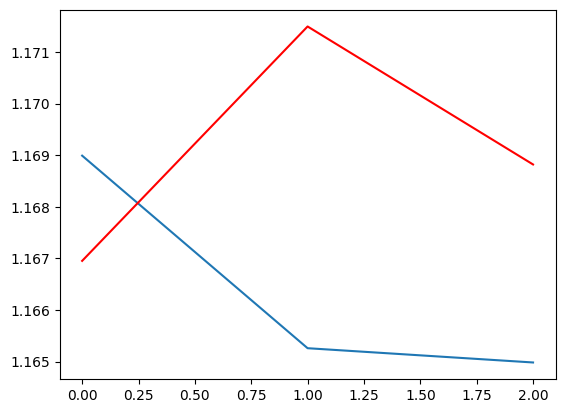

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color='red')

In [ ]:
i = get_scored_val_data()

In [ ]:
x = next(i)

In [ ]:
x[1][0]

[0.0, 0.0, 0.5384615384615384, 0.0, 0.1538461538461538, 0.3076923076923077]

In [ ]:
model.predict( x[0] )

6/6 [==============================] - 1s 45ms/step


array([[0.17127682, 0.15925246, 0.15030429, 0.13711804, 0.15470582,
        0.22734255],
       [0.17127682, 0.15925246, 0.15030429, 0.13711804, 0.15470582,
        0.22734255],
       [0.17127682, 0.15925246, 0.15030429, 0.13711804, 0.15470582,
        0.22734255],
       ...,
       [0.17127682, 0.15925246, 0.15030429, 0.13711804, 0.15470582,
        0.22734255],
       [0.17127682, 0.15925246, 0.15030429, 0.13711804, 0.15470582,
        0.22734255],
       [0.17127682, 0.15925246, 0.15030429, 0.13711804, 0.15470582,
        0.22734255]], dtype=float32)

In [ ]:
x = next(i)
x[1][0]

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
model.predict( x[0] )

9/9 [==============================] - 0s 30ms/step


array([[0.17127682, 0.15925246, 0.15030429, 0.13711804, 0.15470582,
        0.22734255],
       [0.17127682, 0.15925246, 0.15030429, 0.13711804, 0.15470582,
        0.22734255],
       [0.17127682, 0.15925246, 0.15030429, 0.13711804, 0.15470582,
        0.22734255],
       ...,
       [0.17127682, 0.15925246, 0.15030429, 0.13711804, 0.15470582,
        0.22734255],
       [0.17127682, 0.15925246, 0.15030429, 0.13711804, 0.15470582,
        0.22734255],
       [0.17127682, 0.15925246, 0.15030429, 0.13711804, 0.15470582,
        0.22734255]], dtype=float32)